# Homework: Implement a Mixture of Experts Model

## Overview

In this homework, you'll implement a Mixture of Experts (MoE) model for classifying points generated from two Gaussian distributions.

Please submit your Jupyter Notebook with all the completed tasks and questions answered.

In [1]:
# Import Libraries

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Generate the Dataset
def generate_data(n_samples=2000):
  X = torch.zeros(n_samples, 2)
  y = torch.zeros(n_samples, dtype=torch.long)

  # Generate samples from two Gaussian distributions
  X[:n_samples//2] = torch.randn(n_samples//2, 2) + torch.Tensor([3,2])
  X[n_samples//2:] = torch.randn(n_samples//2, 2) + torch.Tensor([-3,2])

  # Labels
  for i in range(X.shape[0]):
    if X[i].norm() > math.sqrt(13):
      y[i] = 1

  X[:, 1] = X[:, 1] - 2

  return X, y

data, labels = generate_data()

Question: Plot the generated dataset. Do you think a linear model would be able to separate the classes well?

Answer.
Because a linear model can only form a straight-line (hyperplane) boundary, it will struggle to accurately separate these two classes.

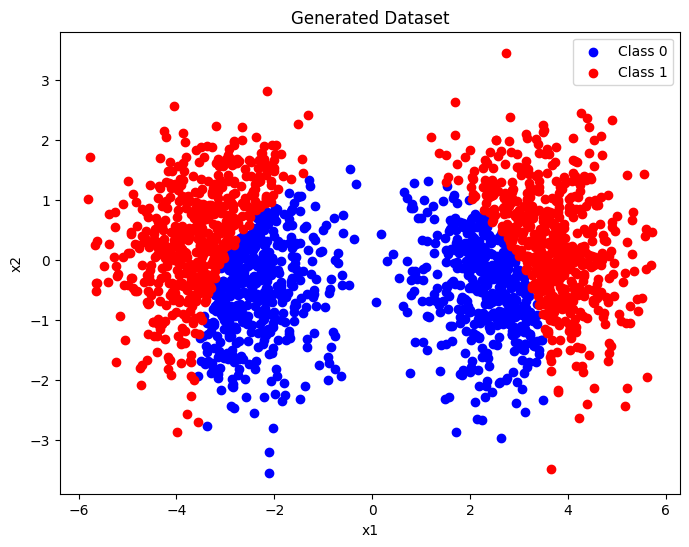

In [3]:
# Visualize the data
# TODO

data_np = data.numpy()
labels_np = labels.numpy()

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(data_np[labels_np == 0, 0], data_np[labels_np == 0, 1], c='blue', label='Class 0')
plt.scatter(data_np[labels_np == 1, 0], data_np[labels_np == 1, 1], c='red', label='Class 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Generated Dataset')
plt.legend()
plt.show()


## Expert Model

Task: Implement the Expert model. It should be a simple neural network with one linear layer.



In [5]:
class Expert(nn.Module):
    def __init__(self, input_dim=2, output_dim=1):
        super(Expert, self).__init__()
        # A single linear layer with no hidden layers
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # Forward pass: compute logits or scores
        return self.linear(x)

## Gating Network

Task: Implement the Gating Network. It should output the probabilities for choosing each expert.

In [6]:
import torch.nn.functional as F

class GatingNetwork(nn.Module):
    def __init__(self, input_dim=2, num_experts=2):
        super(GatingNetwork, self).__init__()
        # A single linear layer that outputs a score for each expert
        self.linear = nn.Linear(input_dim, num_experts)

    def forward(self, x):
        # Apply softmax to convert the scores into probabilities
        return F.softmax(self.linear(x), dim=1)

## Mixture of Experts

Task: Implement the Mixture of Experts model. This model should utilize the Expert and Gating Network models to make a final prediction.

In [7]:
class MixtureOfExperts(nn.Module):
    def __init__(self, num_experts=2, input_dim=2, output_dim=1):
        super(MixtureOfExperts, self).__init__()
        # Create a list of expert models
        self.experts = nn.ModuleList([Expert(input_dim=input_dim, output_dim=output_dim)
                                      for _ in range(num_experts)])
        # Instantiate the gating network which outputs probabilities for each expert
        self.gating_network = GatingNetwork(input_dim=input_dim, num_experts=num_experts)

    def forward(self, x):
        # Compute outputs from each expert. Each expert returns a tensor of shape (batch_size, output_dim)
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)
        # expert_outputs shape: (batch_size, num_experts, output_dim)

        # Obtain gating probabilities for each expert; shape: (batch_size, num_experts)
        gating_probs = self.gating_network(x)
        # Add an extra dimension to align for weighted sum: (batch_size, num_experts, 1)
        gating_probs = gating_probs.unsqueeze(2)

        # Compute the final prediction as a weighted sum of the experts' outputs
        output = torch.sum(gating_probs * expert_outputs, dim=1)
        # output shape: (batch_size, output_dim)

        return output

## Training Loop

Task: Write a training loop to train the Mixture of Experts model. Use binary cross-entropy loss and an Adam optimizer. Also, implement a learning rate scheduler that decays the learning rate.

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Assuming MixtureOfExperts, Expert, and GatingNetwork classes are defined as above

# Define the model, loss, and optimizer
model = MixtureOfExperts(num_experts=2, input_dim=2, output_dim=1)
criterion = nn.BCEWithLogitsLoss()  # Combines a sigmoid layer with BCE loss for numerical stability
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Define a learning rate scheduler that decays the LR by gamma every step_size epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

# Convert data and labels to float tensors
data_tensor = data.float()
labels_tensor = labels.view(-1, 1).float()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # set model to training mode
    optimizer.zero_grad()  # clear gradients

    # Forward pass: compute model output
    outputs = model(data_tensor)
    loss = criterion(outputs, labels_tensor)

    # Backward pass: compute gradients and update parameters
    loss.backward()
    optimizer.step()

    # Decay the learning rate
    scheduler.step()

    # Evaluate accuracy (optional)
    with torch.no_grad():
        # Use sigmoid to get probabilities and threshold at 0.5
        predictions = torch.sigmoid(outputs) >= 0.5
        accuracy = (predictions.float() == labels_tensor).float().mean()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item()*100:.2f}%")


Epoch [1/100], Loss: 1.0966, Accuracy: 48.35%
Epoch [2/100], Loss: 0.9367, Accuracy: 47.60%
Epoch [3/100], Loss: 0.8012, Accuracy: 47.90%
Epoch [4/100], Loss: 0.6984, Accuracy: 50.50%
Epoch [5/100], Loss: 0.6319, Accuracy: 59.75%
Epoch [6/100], Loss: 0.5974, Accuracy: 65.85%
Epoch [7/100], Loss: 0.5831, Accuracy: 68.10%
Epoch [8/100], Loss: 0.5761, Accuracy: 68.65%
Epoch [9/100], Loss: 0.5698, Accuracy: 69.70%
Epoch [10/100], Loss: 0.5641, Accuracy: 70.75%
Epoch [11/100], Loss: 0.5597, Accuracy: 71.45%
Epoch [12/100], Loss: 0.5539, Accuracy: 71.85%
Epoch [13/100], Loss: 0.5425, Accuracy: 72.65%
Epoch [14/100], Loss: 0.5247, Accuracy: 73.80%
Epoch [15/100], Loss: 0.5021, Accuracy: 74.95%
Epoch [16/100], Loss: 0.4786, Accuracy: 75.80%
Epoch [17/100], Loss: 0.4592, Accuracy: 76.60%
Epoch [18/100], Loss: 0.4438, Accuracy: 77.20%
Epoch [19/100], Loss: 0.4261, Accuracy: 77.55%
Epoch [20/100], Loss: 0.4044, Accuracy: 78.85%
Epoch [21/100], Loss: 0.3868, Accuracy: 80.50%
Epoch [22/100], Loss: 

## Decision Boundaries
Task: Plot the decision boundaries of the two experts, the gating network and the final model

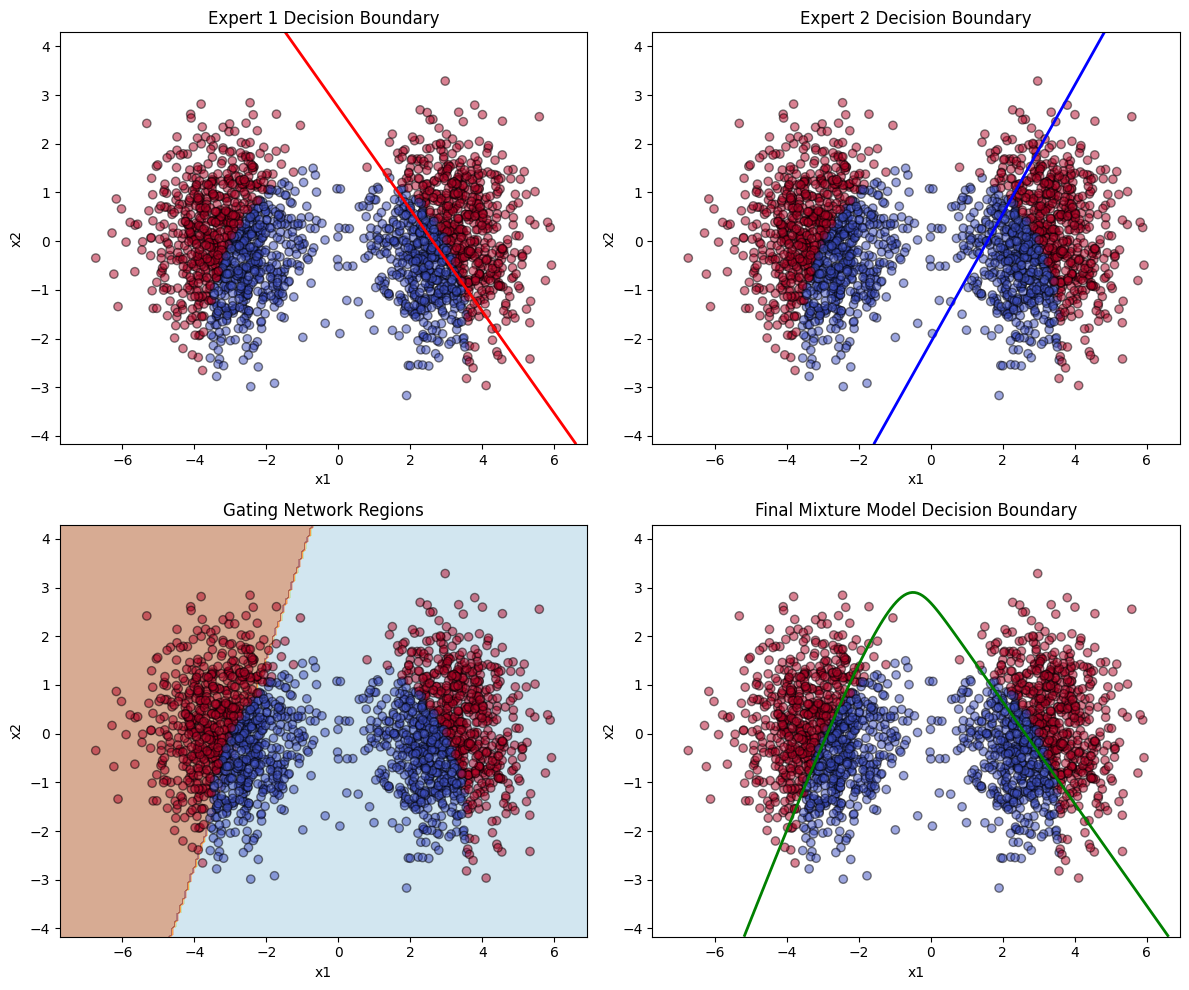

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Determine grid boundaries based on data range
x_min = data_tensor[:, 0].min().item() - 1
x_max = data_tensor[:, 0].max().item() + 1
y_min = data_tensor[:, 1].min().item() - 1
y_max = data_tensor[:, 1].max().item() + 1

# Create a mesh grid of points
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float)

# Evaluate the decision functions for each expert, the gating network, and the final model
with torch.no_grad():
    # Experts produce logits; decision boundary is at logit=0 (i.e. probability 0.5)
    expert1_logits = model.experts[0](grid)  # Shape: (n_points, 1)
    expert2_logits = model.experts[1](grid)

    # Gating network outputs probabilities for each expert
    gating_probs = model.gating_network(grid)  # Shape: (n_points, num_experts)
    gating_decision = torch.argmax(gating_probs, dim=1)  # Which expert is favored

    # Final mixture output (logits)
    final_logits = model(grid)

# Reshape outputs to match the grid shape
expert1_decision = expert1_logits.reshape(xx.shape).numpy()
expert2_decision = expert2_logits.reshape(xx.shape).numpy()
gating_regions = gating_decision.reshape(xx.shape).numpy()
final_decision = final_logits.reshape(xx.shape).numpy()

# Plot decision boundaries and regions
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot Expert 1 decision boundary
axs[0, 0].contour(xx, yy, expert1_decision, levels=[0], colors='red', linewidths=2)
axs[0, 0].scatter(data_tensor[:, 0], data_tensor[:, 1], c=labels_tensor.squeeze(),
                   cmap='coolwarm', edgecolors='k', alpha=0.5)
axs[0, 0].set_title("Expert 1 Decision Boundary")
axs[0, 0].set_xlabel("x1")
axs[0, 0].set_ylabel("x2")

# Plot Expert 2 decision boundary
axs[0, 1].contour(xx, yy, expert2_decision, levels=[0], colors='blue', linewidths=2)
axs[0, 1].scatter(data_tensor[:, 0], data_tensor[:, 1], c=labels_tensor.squeeze(),
                   cmap='coolwarm', edgecolors='k', alpha=0.5)
axs[0, 1].set_title("Expert 2 Decision Boundary")
axs[0, 1].set_xlabel("x1")
axs[0, 1].set_ylabel("x2")

# Plot Gating network decision regions
cmap_gating = plt.cm.Paired
axs[1, 0].contourf(xx, yy, gating_regions, alpha=0.5, cmap=cmap_gating)
axs[1, 0].scatter(data_tensor[:, 0], data_tensor[:, 1], c=labels_tensor.squeeze(),
                   cmap='coolwarm', edgecolors='k', alpha=0.5)
axs[1, 0].set_title("Gating Network Regions")
axs[1, 0].set_xlabel("x1")
axs[1, 0].set_ylabel("x2")

# Plot Final Mixture Model decision boundary
axs[1, 1].contour(xx, yy, final_decision, levels=[0], colors='green', linewidths=2)
axs[1, 1].scatter(data_tensor[:, 0], data_tensor[:, 1], c=labels_tensor.squeeze(),
                   cmap='coolwarm', edgecolors='k', alpha=0.5)
axs[1, 1].set_title("Final Mixture Model Decision Boundary")
axs[1, 1].set_xlabel("x1")
axs[1, 1].set_ylabel("x2")

plt.tight_layout()
plt.show()


Question: Analyze the decision boundaries. What differences do you observe between the experts? How does the gating network decide between the two?


Each expert learns a different straight-line decision boundary, reflecting unique specializations.

Expert 1’s boundary is diagonal in one orientation, while Expert 2’s boundary is diagonal in another.

The gating network partitions the input space, assigning higher probability to whichever expert is more suitable in that region.

By blending the experts’ linear decisions, the final model achieves a more curved boundary that fits the circular separation of the data.

## Bonus Task (2 points)
Try increasing the number of experts. How does the model complexity and decision boundary change? (You don't need to show your code for the new models, just plot the new decision boundaries and explain what did you find from the plots)



Answer.
With more experts, the model gains complexity, allowing it to form more flexible, piecewise-linear decision boundaries.
However, increased complexity also raises the risk of overfitting if the dataset is not large or diverse enough.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# 1. Classes for Experts, GatingNetwork, and MixtureOfExperts
#    (Same as before, but we can now choose num_experts=3)
# -------------------------------------------------------------------

class Expert(nn.Module):
    def __init__(self, input_dim=2, output_dim=1):
        super(Expert, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

class GatingNetwork(nn.Module):
    def __init__(self, input_dim=2, num_experts=2):
        super(GatingNetwork, self).__init__()
        self.linear = nn.Linear(input_dim, num_experts)

    def forward(self, x):
        return F.softmax(self.linear(x), dim=1)

class MixtureOfExperts(nn.Module):
    def __init__(self, num_experts=3, input_dim=2, output_dim=1):
        super(MixtureOfExperts, self).__init__()
        self.num_experts = num_experts
        self.experts = nn.ModuleList([
            Expert(input_dim=input_dim, output_dim=output_dim)
            for _ in range(num_experts)
        ])
        self.gating_network = GatingNetwork(input_dim=input_dim, num_experts=num_experts)

    def forward(self, x):
        # Collect outputs from each expert
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)
        # Gating probabilities
        gating_probs = self.gating_network(x).unsqueeze(2)
        # Weighted sum across experts
        output = torch.sum(gating_probs * expert_outputs, dim=1)
        return output

# -------------------------------------------------------------------
# 2. Generate Data (same as your existing generate_data function)
# -------------------------------------------------------------------

def generate_data(n_samples=2000):
    import math
    X = torch.zeros(n_samples, 2)
    y = torch.zeros(n_samples, dtype=torch.long)

    # Generate samples from two Gaussian distributions
    X[:n_samples//2] = torch.randn(n_samples//2, 2) + torch.Tensor([3, 2])
    X[n_samples//2:] = torch.randn(n_samples//2, 2) + torch.Tensor([-3, 2])

    # Label assignment based on whether the norm exceeds sqrt(13)
    for i in range(X.shape[0]):
        if X[i].norm() > math.sqrt(13):
            y[i] = 1

    # Shift the y-coordinate
    X[:, 1] = X[:, 1] - 2
    return X, y

data, labels = generate_data()

# -------------------------------------------------------------------
# 3. Train Mixture of Experts with 3 Experts
# -------------------------------------------------------------------

model = MixtureOfExperts(num_experts=3, input_dim=2, output_dim=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

data_tensor = data.float()
labels_tensor = labels.view(-1, 1).float()

num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(data_tensor)
    loss = criterion(outputs, labels_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()

    with torch.no_grad():
        predictions = (torch.sigmoid(outputs) >= 0.5).float()
        accuracy = (predictions == labels_tensor).float().mean()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, "
              f"Accuracy: {accuracy.item()*100:.2f}%")


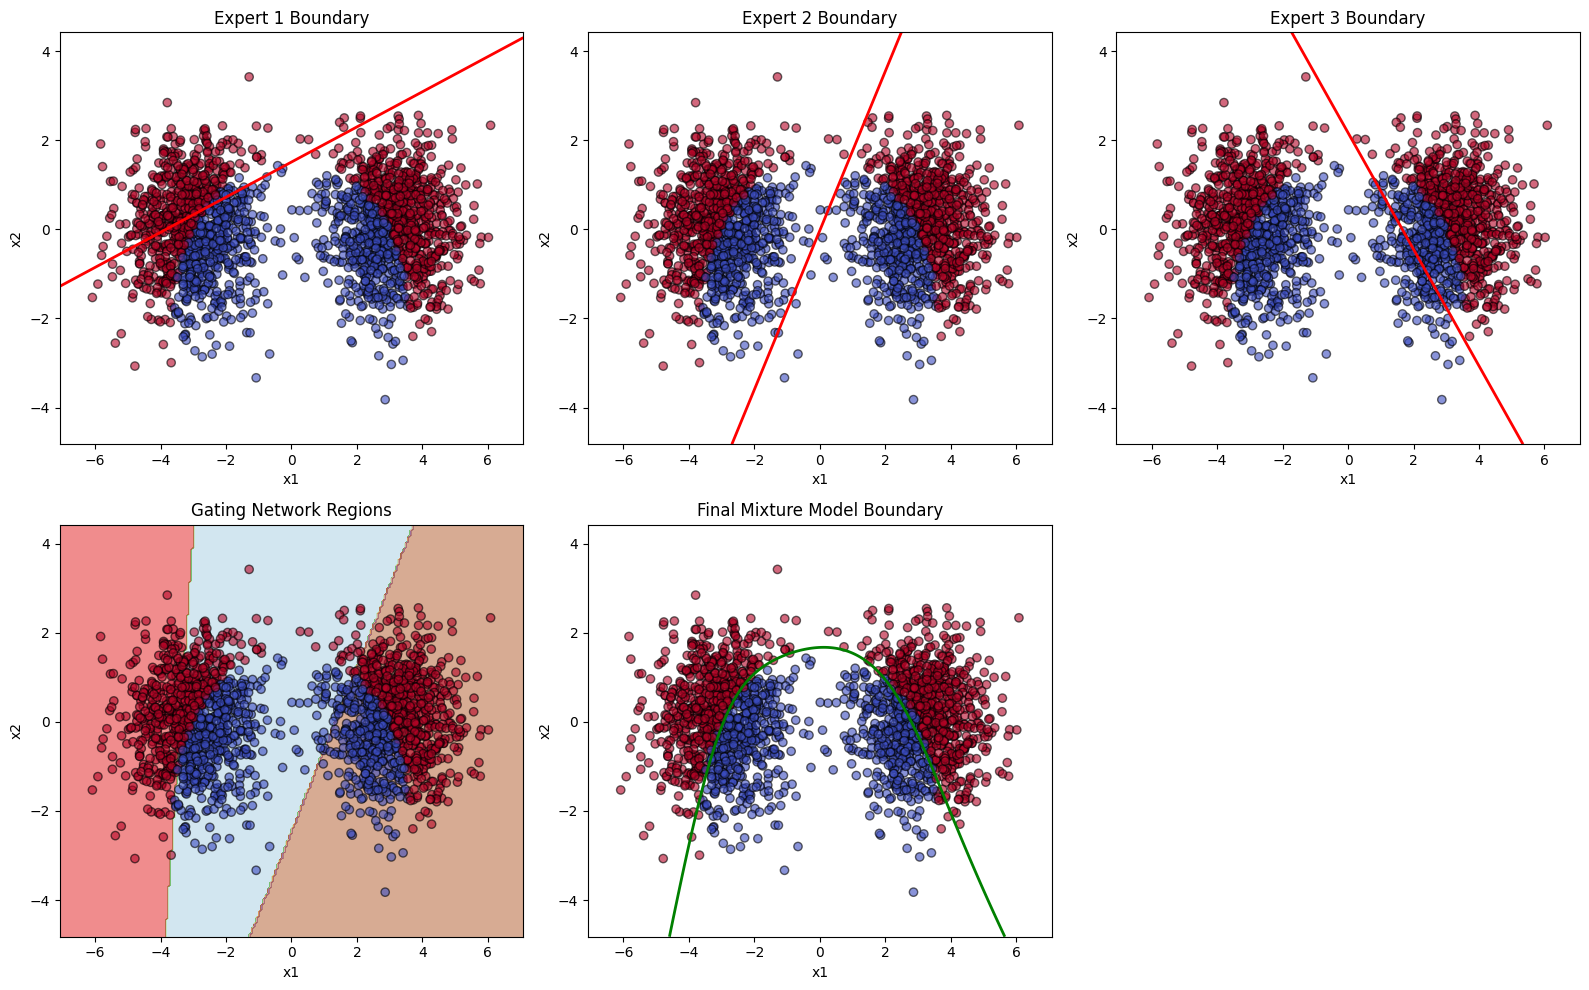

In [32]:

# Determine grid boundaries
x_min, x_max = data_tensor[:, 0].min() - 1, data_tensor[:, 0].max() + 1
y_min, y_max = data_tensor[:, 1].min() - 1, data_tensor[:, 1].max() + 1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float)

with torch.no_grad():
    # Collect each expert's logits
    expert_logits = []
    for i in range(model.num_experts):
        logit = model.experts[i](grid)
        expert_logits.append(logit.reshape(xx.shape).numpy())

    # Gating network region: which expert is favored?
    gating_probs = model.gating_network(grid)  # (n_points, num_experts)
    gating_decision = torch.argmax(gating_probs, dim=1).reshape(xx.shape).numpy()

    # Final mixture output (logits)
    final_logits = model(grid).reshape(xx.shape).numpy()

# Set up subplots: 2 rows, 3 columns for 3 experts + gating + final
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

# Plot each expert's boundary in row 1
for i in range(model.num_experts):
    ax = axs[0, i]
    ax.contour(xx, yy, expert_logits[i], levels=[0], colors=['red'], linewidths=2)
    ax.scatter(data_tensor[:, 0], data_tensor[:, 1], c=labels_tensor.squeeze(),
               cmap='coolwarm', edgecolors='k', alpha=0.6)
    ax.set_title(f"Expert {i+1} Boundary")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

# Plot gating regions (row 2, col 1)
cmap_gating = plt.cm.Paired
axs[1, 0].contourf(xx, yy, gating_decision, alpha=0.5, cmap=cmap_gating)
axs[1, 0].scatter(data_tensor[:, 0], data_tensor[:, 1], c=labels_tensor.squeeze(),
                  cmap='coolwarm', edgecolors='k', alpha=0.6)
axs[1, 0].set_title("Gating Network Regions")
axs[1, 0].set_xlabel("x1")
axs[1, 0].set_ylabel("x2")

# Plot final mixture boundary (row 2, col 2)
axs[1, 1].contour(xx, yy, final_logits, levels=[0], colors=['green'], linewidths=2)
axs[1, 1].scatter(data_tensor[:, 0], data_tensor[:, 1], c=labels_tensor.squeeze(),
                  cmap='coolwarm', edgecolors='k', alpha=0.6)
axs[1, 1].set_title("Final Mixture Model Boundary")
axs[1, 1].set_xlabel("x1")
axs[1, 1].set_ylabel("x2")

# Hide the last subplot if you want (row 2, col 3)
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()
